<a href="https://colab.research.google.com/github/sayakpaul/TF-2.0-Hacks/blob/master/Variational_AutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The code is taken from https://www.tensorflow.org/beta/guide/keras/custom_layers_and_models#putting_it_all_together_an_end-to-end_example. The intention is to visualize the images that are reconstructed by a VAE. 

In [0]:
!pip install tensorflow-gpu==2.0.0-beta1

In [1]:
# Imports
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers
import numpy as np
np.random.seed(7)

print(tf.__version__)

2.0.0-beta1


In [0]:
# Data prep
(x_train, _), _ = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape(60000, 784).astype('float32') / 255

train_dataset = tf.data.Dataset.from_tensor_slices(x_train)
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

In [0]:
class Sampling(layers.Layer):
  """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

  def call(self, inputs):
    z_mean, z_log_var = inputs
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon


class Encoder(layers.Layer):
  """Maps MNIST digits to a triplet (z_mean, z_log_var, z)."""

  def __init__(self,
               latent_dim=32,
               intermediate_dim=64):
    super(Encoder, self).__init__()
    self.dense_proj = layers.Dense(intermediate_dim, activation='relu')
    self.dense_mean = layers.Dense(latent_dim)
    self.dense_log_var = layers.Dense(latent_dim)
    self.sampling = Sampling()

  def call(self, inputs):
    x = self.dense_proj(inputs)
    z_mean = self.dense_mean(x)
    z_log_var = self.dense_log_var(x)
    z = self.sampling((z_mean, z_log_var))
    return z_mean, z_log_var, z


class Decoder(layers.Layer):
  """Converts z, the encoded digit vector, back into a readable digit."""

  def __init__(self,
               original_dim,
               intermediate_dim=64):
    super(Decoder, self).__init__()
    self.dense_proj = layers.Dense(intermediate_dim, activation='relu')
    self.dense_output = layers.Dense(original_dim, activation='sigmoid')

  def call(self, inputs):
    x = self.dense_proj(inputs)
    return self.dense_output(x)


class VariationalAutoEncoder(tf.keras.Model):
  """Combines the encoder and decoder into an end-to-end model for training."""

  def __init__(self,
               original_dim,
               intermediate_dim=64,
               latent_dim=32):
    super(VariationalAutoEncoder, self).__init__()
    self.original_dim = original_dim
    self.encoder = Encoder(latent_dim=latent_dim,
                           intermediate_dim=intermediate_dim)
    self.decoder = Decoder(original_dim, intermediate_dim=intermediate_dim)

  def call(self, inputs):
    z_mean, z_log_var, z = self.encoder(inputs)
    reconstructed = self.decoder(z)
    # Add KL divergence regularization loss.
    kl_loss = - 0.5 * tf.reduce_mean(
        z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
    self.add_loss(kl_loss)
    return reconstructed


In [0]:
# Instantiate the VAE class
num_features = 784
nodes = 64
latent_vars = 32
vae = VariationalAutoEncoder(num_features, nodes, latent_vars)

In [0]:
# Optimizer and reconstruction loss function
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
mse_loss_fn = tf.keras.losses.MeanSquaredError()

# We want to average out the loss after each epoch
loss_metric = tf.keras.metrics.Mean()

In [9]:
# Iterate over epochs.
for epoch in range(3):
  print('Start of epoch %d' % (epoch,))

  # Iterate over the batches of the dataset.
  for step, x_batch_train in enumerate(train_dataset):
    with tf.GradientTape() as tape:
      reconstructed = vae(x_batch_train)
      # Compute reconstruction loss
      loss = mse_loss_fn(x_batch_train, reconstructed)
      loss += sum(vae.losses)  # Add KLD regularization loss

    grads = tape.gradient(loss, vae.trainable_weights)
    optimizer.apply_gradients(zip(grads, vae.trainable_weights))

    loss_metric(loss)

    if step % 100 == 0:
      print('step {}: mean loss = {}'.format(step, loss_metric.result()))

Start of epoch 0
step 0: mean loss = 0.3513181805610657
step 100: mean loss = 0.12723110616207123
step 200: mean loss = 0.10005825012922287
step 300: mean loss = 0.08973503857851028
step 400: mean loss = 0.08461252599954605
step 500: mean loss = 0.08121258020401001
step 600: mean loss = 0.07903553545475006
step 700: mean loss = 0.07738673686981201
step 800: mean loss = 0.07619763910770416
step 900: mean loss = 0.07514350861310959
Start of epoch 1
step 0: mean loss = 0.0748547613620758
step 100: mean loss = 0.07418126612901688
step 200: mean loss = 0.07366356253623962
step 300: mean loss = 0.07317443937063217
step 400: mean loss = 0.07282574474811554
step 500: mean loss = 0.07242324203252792
step 600: mean loss = 0.0721222311258316
step 700: mean loss = 0.07182537019252777
step 800: mean loss = 0.0715859979391098
step 900: mean loss = 0.07131179422140121
Start of epoch 2
step 0: mean loss = 0.07124077528715134
step 100: mean loss = 0.07106111198663712
step 200: mean loss = 0.07092139869

In [10]:
# Inspection
reconstructed.shape, x_batch_train.shape

(TensorShape([32, 784]), TensorShape([32, 784]))

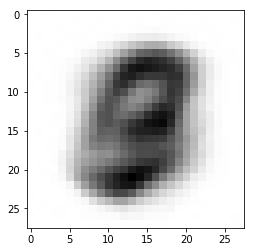

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

sample_recon_image = reconstructed.numpy()[1]
sample_recon_image = sample_recon_image.reshape(28, 28)

plt.imshow(sample_recon_image, cmap='binary')
plt.show()

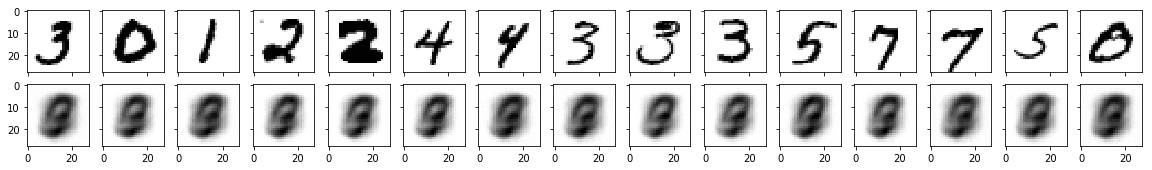

In [12]:
##########################
### VISUALIZATION
##########################

n_images = 15
image_width = 28

fig, axes = plt.subplots(nrows=2, ncols=n_images, 
                         sharex=True, sharey=True, figsize=(20, 2.5))
orig_images = x_batch_train[:n_images].numpy()
decoded_images = reconstructed[:n_images].numpy()

for i in range(n_images):
    for ax, img in zip(axes, [orig_images, decoded_images]):
        curr_img = img[i]
        ax[i].imshow(curr_img.reshape((image_width, image_width)), cmap='binary')